In [1]:
import numpy as np
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt

def load_model_and_image():
    """Load a pre-trained ViT model and a sample image."""
    # Load the model
    processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

    # Load a sample image
    url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    raw_image = Image.open(requests.get(url, stream=True).raw)
    image = torch.tensor(np.array(raw_image)).permute(2, 0, 1)

    return processor, model, image

load_model_and_image()


/opt/homebrew/Caskroom/miniconda/base/envs/aisb/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/aisb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(ViTImageProcessor {
   "do_convert_rgb": null,
   "do_normalize": true,
   "do_rescale": true,
   "do_resize": true,
   "image_mean": [
     0.5,
     0.5,
     0.5
   ],
   "image_processor_type": "ViTImageProcessor",
   "image_std": [
     0.5,
     0.5,
     0.5
   ],
   "resample": 2,
   "rescale_factor": 0.00392156862745098,
   "size": {
     "height": 224,
     "width": 224
   }
 },
 ViTForImageClassification(
   (vit): ViTModel(
     (embeddings): ViTEmbeddings(
       (patch_embeddings): ViTPatchEmbeddings(
         (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
       )
       (dropout): Dropout(p=0.0, inplace=False)
     )
     (encoder): ViTEncoder(
       (layer): ModuleList(
         (0-11): 12 x ViTLayer(
           (attention): ViTAttention(
             (attention): ViTSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               

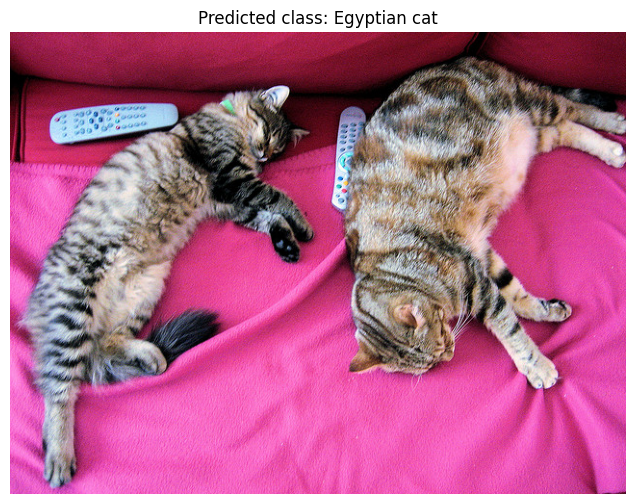

In [2]:
def classify_image(processor, model, image):
    """
    Classify an image using the ViT model.

    Args:
        processor: ViT image processor
        model: ViT classification model
        image: Image tensor in CHW format

    Returns:
        predicted_class_idx: Index of predicted class
        predicted_class_name: Name of predicted class
    """
    # TODO: Process the image and get model predictions
    # - Use processor to prepare inputs
    #   - The processor takes in the image and returns a tensor with normalized pixel values that the model was trained on
    #   - It also crops/resizes the image to the expected input size
    inputs = processor(images=image, return_tensors="pt")
    # - Run the model to get logits
    outputs = model(**inputs)
    # - Find and return the predicted class index and name
    logits = outputs.logits
    # returns index of max value: logits.argmax(-1)
    predicted_class_idx = logits.argmax(-1).item()

    return predicted_class_idx, model.config.id2label[predicted_class_idx]


processor, model, image = load_model_and_image()
class_idx, class_name = classify_image(processor, model, image)

plt.figure(figsize=(8, 6))
plt.imshow(image.numpy().transpose(1, 2, 0).astype("uint8"))
plt.title(f"Predicted class: {class_name}")
plt.axis("off")
plt.show()

# Noise

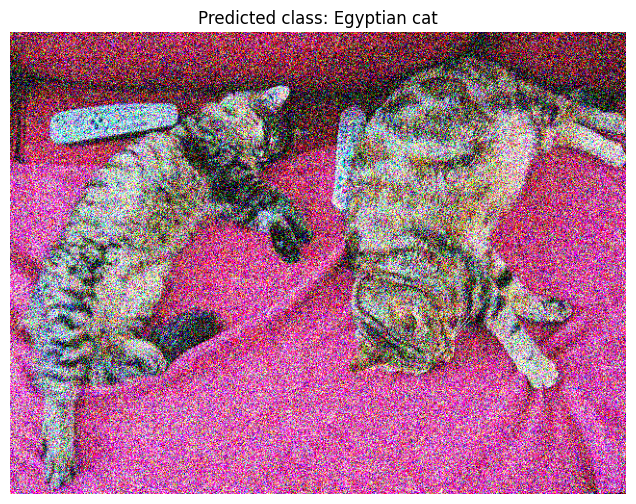

In [3]:
processor, model, image = load_model_and_image()

noise = torch.randn_like(image, dtype=torch.float32) * 100
attack = torch.clip(image + noise.int(), 0, 255)

class_idx, class_name = classify_image(processor, model, attack)

plt.figure(figsize=(8, 6))
plt.imshow(attack.numpy().transpose(1, 2, 0).astype("uint8"))
plt.title(f"Predicted class: {class_name}")
plt.axis("off")
plt.show()

# Adversarial perturbation

In [19]:
import tqdm

def create_adversarial_perturbation(processor, model, image, target_class_id, steps=10, lr=0.1):
    """
    Create an adversarial perturbation to make the model classify the image as target_class.

    Args:
        processor: ViT image processor
        model: ViT classification model
        image: Original image tensor
        target_class_id: Target class index
        steps: Number of optimization steps
        lr: Learning rate

    Returns:
        perturbation: The adversarial perturbation
        perturbed_image: The adversarially perturbed image
        success: Whether the attack succeeded (the target class was predicted)
    """
    # TODO: Implement adversarial perturbation generation
    # - Initialize a random perturbation with requires_grad=True
    # - Use an optimizer to update the perturbation
    # - Minimize cross-entropy loss with target class
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs["pixel_values"]

    # convert to dictionary for adam
    perturbation = torch.randn_like(inputs, dtype=torch.float32) * 0.00005
    perturbation = perturbation.requires_grad_(True)
    optimizer = torch.optim.Adam([perturbation], lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Test adversarial attack
    target_class = "daisy"
    target_class_id = model.config.label2id[target_class]
    y = torch.tensor([target_class_id])

    success = False
    for i in tqdm.tqdm(range(steps)):
        attack = torch.clip(inputs + perturbation, -1, 1)
        # - Run the model to get logits
        outputs = model(pixel_values=attack)

        loss = loss_fn(outputs.logits, y)

        # Get the predicted class ID from the logits
        current_pred_id = outputs.logits.argmax(-1).item()

        # Check if the prediction matches the target
        if current_pred_id == target_class_id:
            print(f"\n✅ Attack successful at step {i + 1}! Target class '{target_class}' was predicted.")
            success = True
            break  # Exit the loop early

            # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    perturbed_image = inputs + perturbation
    return perturbation.detach(), perturbed_image.detach(), success

target_class = "daisy"
target_class_id = model.config.label2id[target_class]

print(f"\nAttempting to change prediction to: {target_class}")
print("=" * 60)

perturbation, perturbed_image, success = create_adversarial_perturbation(
    processor, model, image, target_class_id, steps=10, lr=0.1
)

print(f"\nAttack {'succeeded' if success else 'failed'}!")


Attempting to change prediction to: daisy


 50%|█████     | 5/10 [00:02<00:02,  2.08it/s]


✅ Attack successful at step 6! Target class 'daisy' was predicted.

Attack succeeded!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2970871..1.2926337].


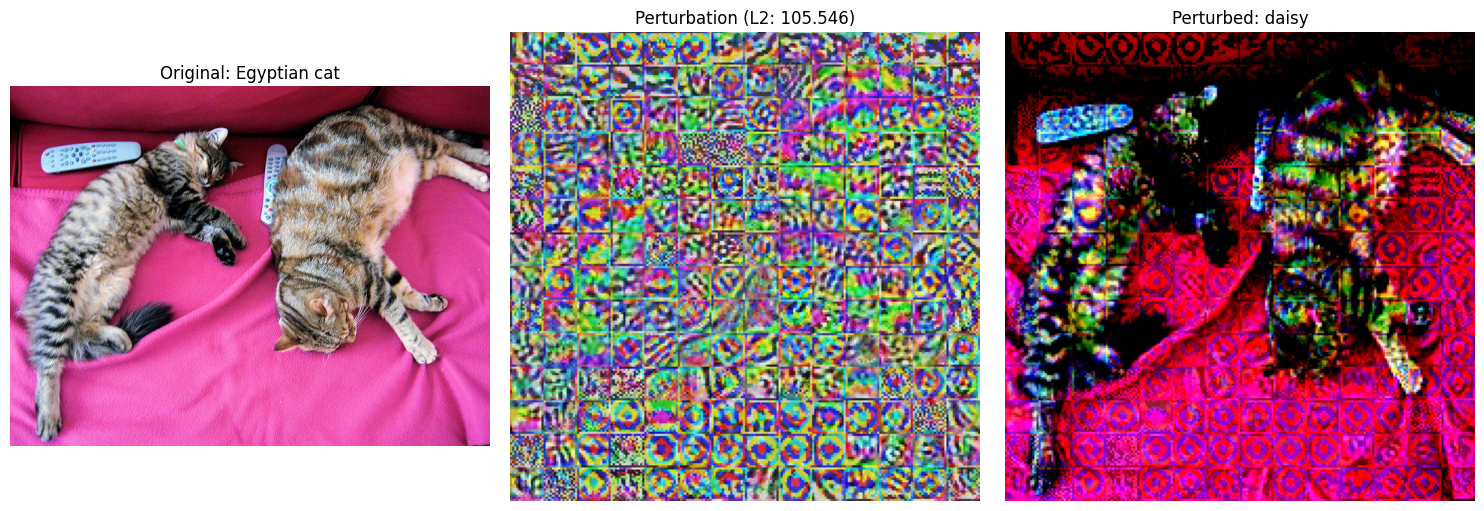

In [20]:
# %%
# Visualize the original, perturbation, and perturbed image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(image.numpy().transpose(1, 2, 0).astype("uint8"))
_, orig_class = classify_image(processor, model, image)
axes[0].set_title(f"Original: {orig_class}")
axes[0].axis("off")

# Perturbation (normalized for visualization)
pert_vis = perturbation.squeeze().permute(1, 2, 0).numpy()
# Normalize to [0, 1] for visualization
pert_vis = (pert_vis - pert_vis.min()) / (pert_vis.max() - pert_vis.min())
axes[1].imshow(pert_vis)
axes[1].set_title(f"Perturbation (L2: {perturbation.norm().item():.3f})")
axes[1].axis("off")

# Perturbed image
perturbed_vis = perturbed_image.squeeze().permute(1, 2, 0).numpy()
axes[2].imshow(perturbed_vis)
# Get prediction for perturbed image
outputs = model(pixel_values=perturbed_image)
pred_idx = outputs.logits.argmax(-1).item()
axes[2].set_title(f"Perturbed: {model.config.id2label[pred_idx]}")
axes[2].axis("off")

plt.tight_layout()
plt.show()


# Constrained Adversarial Attack

In [ ]:
"""
    Create an adversarial perturbation, but add l2 and l∞ constraints.

    Args:
        processor: ViT image processor
        model: ViT classification model
        image: Original image tensor
        target_class_id: Target class index
        steps: Number of optimization steps
        lr: Learning rate
        l2_reg: L2 regularization strength
        l_inf_bound: Maximum allowed change per pixel (L∞ constraint)

    Returns:
        perturbation: The adversarial perturbation
        perturbed_image: The adversarially perturbed image
        success: Whether the attack succeeded
        history: Dictionary with loss and prediction history
    """
def create_constrained_adversarial_attack(
    processor, model, image, target_class_id, steps=20, lr=0.05, l2_reg=2.0, l_inf_bound=0.1
):
    
    # TODO: Implement constrained adversarial attack
    # - Add L2 regularization to the loss
    # - Clamp perturbation to respect L∞ bounds
    # - Ensure final pixel values stay in [0, 1]
    # - Track loss and predictions over time
    pass
